In [ ]:
!pip install kaggle

In [1]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d saramhai/people-with-and-without-glasses-dataset


Dataset URL: https://www.kaggle.com/datasets/saramhai/people-with-and-without-glasses-dataset
License(s): unknown
 99% 459M/465M [00:01<00:00, 280MB/s]
100% 465M/465M [00:01<00:00, 334MB/s]


In [3]:
!ls

 kaggle.json
 my_resnet_model.h5
 people-with-and-without-glasses-dataset.zip
 sample_data
'WhatsApp Image 2025-06-23 at 11.23.26_60e19f7a.jpg'
'WhatsApp Image 2025-06-23 at 11.28.14_5568e9ae.jpg'
'WhatsApp Image 2025-06-24 at 10.39.46_b8854ddc.jpg'
'WhatsApp Image 2025-06-24 at 10.40.21_3019f507.jpg'
'WhatsApp Image 2025-06-24 at 22.54.22_61a6fee4.jpg'
'WhatsApp Image 2025-06-24 at 22.58.21_df5a1930.jpg'
'WhatsApp Image 2025-06-24 at 23.01.08_7fec90e5.jpg'
'WhatsApp Image 2025-06-24 at 23.03.09_850a019d.jpg'
'WhatsApp Image 2025-06-24 at 23.08.54_135888a8.jpg'
'WhatsApp Image 2025-06-24 at 23.10.34_f83765a3.jpg'


In [4]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/people-with-and-without-glasses-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [5]:
!ls

 Images
 kaggle.json
 my_resnet_model.h5
 people-with-and-without-glasses-dataset.zip
 sample_data
'WhatsApp Image 2025-06-23 at 11.23.26_60e19f7a.jpg'
'WhatsApp Image 2025-06-23 at 11.28.14_5568e9ae.jpg'
'WhatsApp Image 2025-06-24 at 10.39.46_b8854ddc.jpg'
'WhatsApp Image 2025-06-24 at 10.40.21_3019f507.jpg'
'WhatsApp Image 2025-06-24 at 22.54.22_61a6fee4.jpg'
'WhatsApp Image 2025-06-24 at 22.58.21_df5a1930.jpg'
'WhatsApp Image 2025-06-24 at 23.01.08_7fec90e5.jpg'
'WhatsApp Image 2025-06-24 at 23.03.09_850a019d.jpg'
'WhatsApp Image 2025-06-24 at 23.08.54_135888a8.jpg'
'WhatsApp Image 2025-06-24 at 23.10.34_f83765a3.jpg'


In [6]:
# Install Kaggle if downloading from Kaggle (optional)
# !pip install -q kaggle

# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [7]:
# Set image target size for ResNet
image_size = (224, 224)
image_dir = '/content/Images'  # Change if needed

# Load images and labels
data = []
labels = []

for label_dir in ['glasses', 'no_glasses']:
    folder_path = os.path.join(image_dir, label_dir)
    label = 1 if label_dir == 'glasses' else 0

    for fname in os.listdir(folder_path):
        img_path = os.path.join(folder_path, fname)
        try:
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0  # normalize to [0, 1]
            data.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Skipping {img_path}: {e}")

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)


In [8]:
batch_size = 32

train_datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()  # no augmentation for validation

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)


In [9]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze ResNet base

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# Optional: Stop training if no improvement for 3 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2774s 22s/step - accuracy: 0.5271 - auc_2: 0.5126 - loss: 0.7214 - val_accuracy: 0.5630 - val_auc_2: 0.4977 - val_loss: 0.6919
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2793s 23s/step - accuracy: 0.5237 - auc_2: 0.4982 - loss: 0.7084 - val_accuracy: 0.5467 - val_auc_2: 0.4752 - val_loss: 0.6926
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2727s 22s/step - accuracy: 0.5416 - auc_2: 0.5109 - loss: 0.7005 - val_accuracy: 0.5142 - val_auc_2: 0.4066 - val_loss: 0.6935
Epoch 4/10
 68/123 ━━━━━━━━━━━━━━━━━━━━ 19:24 21s/step - accuracy: 0.5611 - auc_2: 0.5069 - loss: 0.6991

KeyboardInterrupt: 

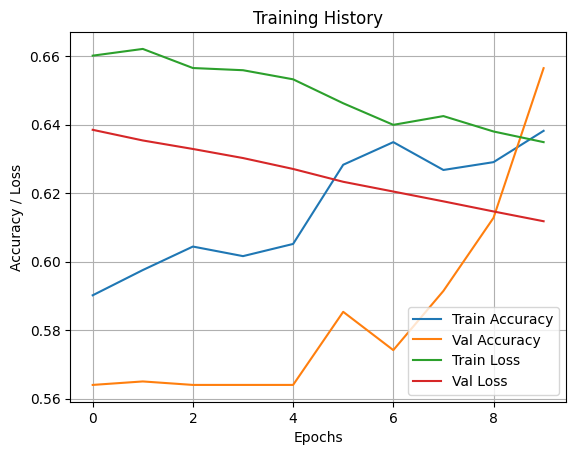

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def predict_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)[0][0]
    return f"{'Glasses' if pred >= 0.5 else 'No Glasses'} (Confidence: {pred:.2f})"


In [ ]:
print(predict_image('/content/WhatsApp Image 2025-06-24 at 22.54.22_61a6fee4.jpg'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Glasses (Confidence: 0.79)


In [ ]:
print(predict_image('/content/WhatsApp Image 2025-06-23 at 11.28.14_5568e9ae.jpg'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
No Glasses (Confidence: 0.43)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


31/31 ━━━━━━━━━━━━━━━━━━━━ 151s 5s/step

Classification Report:
              precision    recall  f1-score   support

  No Glasses       0.90      0.27      0.41       430
     Glasses       0.63      0.98      0.77       554

    accuracy                           0.67       984
   macro avg       0.76      0.62      0.59       984
weighted avg       0.75      0.67      0.61       984


Accuracy  : 0.6657
Precision : 0.6313
Recall    : 0.9765
F1 Score  : 0.7668


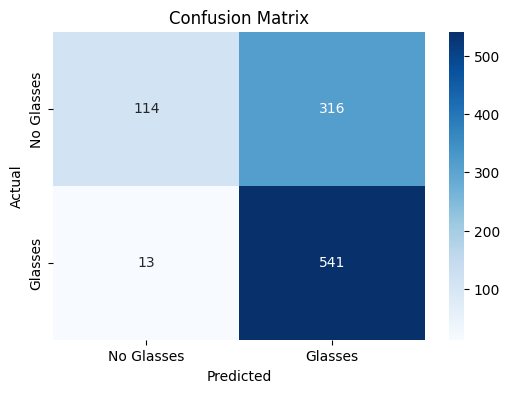

In [ ]:
# Predict probabilities on validation set
y_pred_prob = model.predict(X_val)
# Convert probabilities to binary class predictions
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["No Glasses", "Glasses"]))

# Print accuracy, precision, recall, F1 manually
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"\nAccuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Glasses", "Glasses"], yticklabels=["No Glasses", "Glasses"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save('my_resnet_model.h5')  # Saves the full model (architecture + weights)


In [ ]:
from google.colab import files
files.download('my_resnet_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('my_resnet_model.h5')


In [ ]:
print(predict_image('/content/WhatsApp Image 2025-06-24 at 22.58.21_df5a1930.jpg'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
Glasses (Confidence: 0.59)


In [ ]:
print(predict_image('/content/WhatsApp Image 2025-06-24 at 23.03.09_850a019d.jpg'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Glasses (Confidence: 0.54)


In [ ]:
print(predict_image('/content/WhatsApp Image 2025-06-23 at 11.23.26_60e19f7a.jpg'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Glasses (Confidence: 0.50)


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('my_resnet_model.h5')


In [ ]:
print(predict_image('/content/WhatsApp Image 2025-06-24 at 23.03.09_850a019d.jpg'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Glasses (Confidence: 0.54)


In [ ]:
print(predict_image('/content/WhatsApp Image 2025-06-24 at 23.03.09_850a019d.jpg'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Glasses (Confidence: 0.54)


In [ ]:
import numpy as np
from collections import Counter

print("Labels:", Counter(labels))


Labels: Counter({1: 2769, 0: 2151})


In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)


In [ ]:
base_model.trainable = False


In [ ]:
# First, freeze everything
base_model.trainable = False

# Then unfreeze last few layers
for layer in base_model.layers[-30:]:  # unfreeze last 30 layers
    layer.trainable = True


In [ ]:
model.compile(
    optimizer=Adam(1e-5),  # Smaller learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, lr_reduce],
    class_weight=class_weights  # Optional if computed
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 843s 7s/step - accuracy: 0.6599 - loss: 0.6444 - val_accuracy: 0.7866 - val_loss: 0.6139 - learning_rate: 1.0000e-05
Epoch 2/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 814s 7s/step - accuracy: 0.6721 - loss: 0.6405 - val_accuracy: 0.8262 - val_loss: 0.6147 - learning_rate: 1.0000e-05
Epoch 3/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6725 - loss: 0.6404
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
123/123 ━━━━━━━━━━━━━━━━━━━━ 849s 7s/step - accuracy: 0.6726 - loss: 0.6403 - val_accuracy: 0.8272 - val_loss: 0.6151 - learning_rate: 1.0000e-05
Epoch 4/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 805s 7s/step - accuracy: 0.6721 - loss: 0.6379 - val_accuracy: 0.8252 - val_loss: 0.6151 - learning_rate: 5.0000e-06
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
class_weight=class_weights  # ➜ remove or comment out this line


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))


In [ ]:
def predict_and_show(img_path):
    from matplotlib import pyplot as plt
    img = load_clean_image(img_path, image_size)
    if img is None:
        print("Invalid image")
        return
    img_array = np.expand_dims(img, axis=0)
    prediction = model.predict(img_array)[0][0]
    label = "Glasses" if prediction >= 0.5 else "No Glasses"

    plt.imshow(img)
    plt.title(f"Prediction: {label} ({prediction:.2f})")
    plt.axis('off')
    plt.show()


In [ ]:
print(predict_image('/content/WhatsApp Image 2025-06-24 at 23.03.09_850a019d.jpg'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Glasses (Confidence: 0.53)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


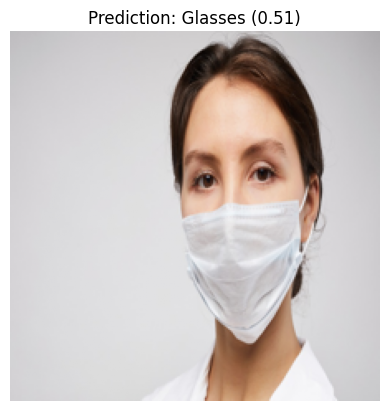

In [ ]:
predict_and_show('/content/WhatsApp Image 2025-06-24 at 10.40.21_3019f507.jpg')


31/31 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step

Classification Report:
              precision    recall  f1-score   support

  No Glasses       0.87      0.60      0.71       430
     Glasses       0.75      0.93      0.83       554

    accuracy                           0.79       984
   macro avg       0.81      0.77      0.77       984
weighted avg       0.80      0.79      0.78       984


Accuracy  : 0.7866
Precision : 0.7507
Recall    : 0.9296
F1 Score  : 0.8306


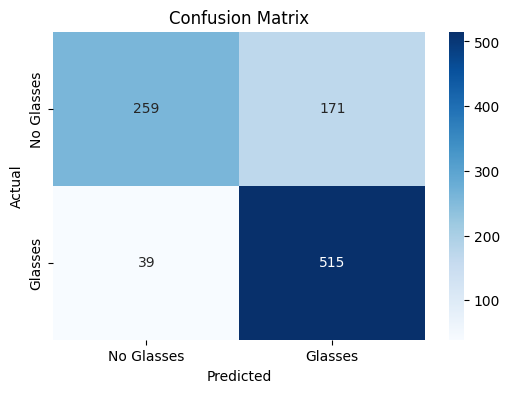

In [ ]:
# Predict probabilities on validation set
y_pred_prob = model.predict(X_val)
# Convert probabilities to binary class predictions
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["No Glasses", "Glasses"]))

# Print accuracy, precision, recall, F1 manually
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"\nAccuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Glasses", "Glasses"], yticklabels=["No Glasses", "Glasses"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
)


In [ ]:
base_model.trainable = True
# Freeze only the first ~100 layers
for layer in base_model.layers[:100]:
    layer.trainable = False


In [ ]:
model.compile(
    optimizer=Adam(1e-5),  # Lower learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)


In [ ]:
import tensorflow as tf


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)


In [ ]:
model.compile(optimizer=Adam(1e-5), loss=loss, metrics=['accuracy'])


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)


In [ ]:
def show_uncertain_predictions(threshold=0.45, upper=0.55):
    for i, (img, true_label) in enumerate(zip(X_val, y_val)):
        pred = model.predict(np.expand_dims(img, axis=0))[0][0]
        if threshold < pred < upper:
            plt.imshow(img)
            plt.title(f"Pred: {pred:.2f}, True: {'Glasses' if true_label == 1 else 'No Glasses'}")
            plt.axis('off')
            plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


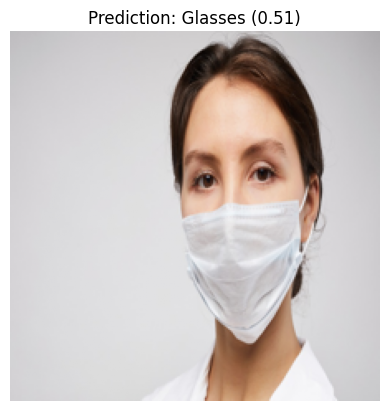

In [ ]:
predict_and_show('/content/WhatsApp Image 2025-06-24 at 10.40.21_3019f507.jpg')


31/31 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step

Classification Report:
              precision    recall  f1-score   support

  No Glasses       0.87      0.60      0.71       430
     Glasses       0.75      0.93      0.83       554

    accuracy                           0.79       984
   macro avg       0.81      0.77      0.77       984
weighted avg       0.80      0.79      0.78       984


Accuracy  : 0.7866
Precision : 0.7507
Recall    : 0.9296
F1 Score  : 0.8306


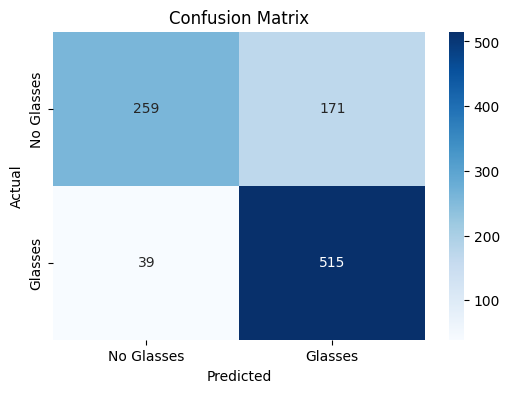

In [ ]:
# Predict probabilities on validation set
y_pred_prob = model.predict(X_val)
# Convert probabilities to binary class predictions
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["No Glasses", "Glasses"]))

# Print accuracy, precision, recall, F1 manually
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"\nAccuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Glasses", "Glasses"], yticklabels=["No Glasses", "Glasses"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [12]:
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
model.compile(
    optimizer=Adam(1e-5),
    loss=loss,
    metrics=['accuracy', tf.keras.metrics.AUC()]
)


In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Dummy input shape
input_shape = (224, 224, 3)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# Use smoothed loss
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)

model.compile(optimizer=Adam(1e-5), loss=loss, metrics=['accuracy', tf.keras.metrics.AUC()])


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


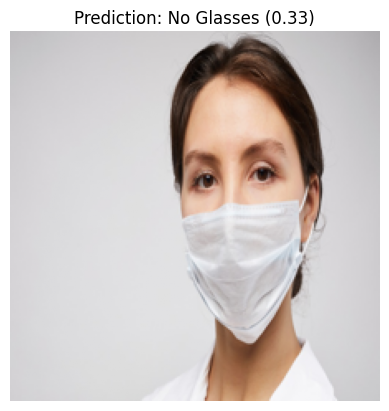

In [ ]:
predict_and_show('/content/WhatsApp Image 2025-06-24 at 10.40.21_3019f507.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


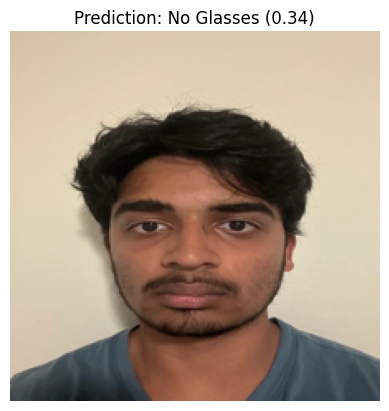

In [ ]:
predict_and_show('/content/WhatsApp Image 2025-06-24 at 23.03.09_850a019d.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


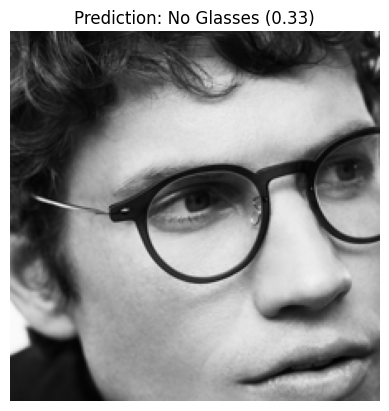

In [ ]:
predict_and_show('/content/WhatsApp Image 2025-06-24 at 22.58.21_df5a1930.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


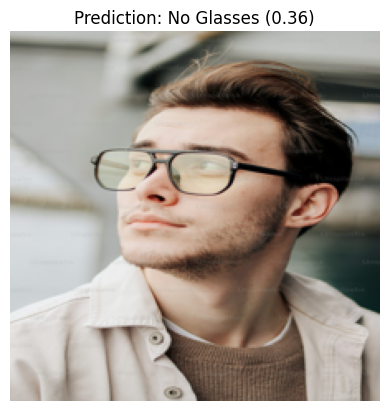

In [ ]:
predict_and_show('/content/WhatsApp Image 2025-06-24 at 22.54.22_61a6fee4.jpg')


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()  # No augmentation for validation

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


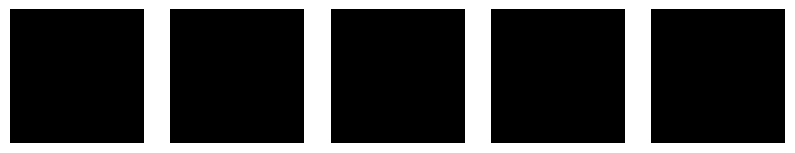

In [15]:
# Preview 5 augmented samples of a single image
import matplotlib.pyplot as plt

example = X_train[0].reshape((1,) + X_train[0].shape)  # reshape to batch

aug_iter = train_datagen.flow(example, batch_size=1)

plt.figure(figsize=(10, 2))
for i in range(5):
    batch = next(aug_iter)[0]
    plt.subplot(1, 5, i+1)
    plt.imshow(batch)
    plt.axis('off')
plt.show()


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, lr_reduce],
    class_weight=class_weights
)


In [ ]:
predict_and_show('/content/WhatsApp Image 2025-06-24 at 22.54.22_61a6fee4.jpg')


NameError: name 'load_clean_image' is not defined